# Pandas for time series


**Note:** For a recap on the core concepts on Pandas (data structures, aggregation operations, string methods, label and position indexing, groupby) see `01a-pandas_recap.ipynb`.

Now we'll focus on Pandas for timeseries and issues related to dates.

Authors: [Alexandre Gramfort](http://alexandre.gramfort.net)
         [Thomas Moreau](https://tommoral.github.io)

(based on Wes McKinney's book "Python for Data Analysis" O'REILLY,
and the pandas materials from Joris Van den Bossche and Stijn Van Hoey,
as well as the Python Data Science Handbook by Jake VanderPlas)

Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)

In [1]:
import pandas as pd  # THE standard way of importing pandas

Some imports

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

# Working with time series data

## Dates using the standard library: `datetime` and `dateutil` modules

Standard Python contains the `datetime` module to handle with date and time data:

In [3]:
import datetime

In [4]:
dt = datetime.datetime(year=2016, month=12, day=19, hour=13, minute=30)
dt

datetime.datetime(2016, 12, 19, 13, 30)

In [5]:
print(dt) # .day,...

2016-12-19 13:30:00


In [6]:
dt.month

12

In [7]:
print(dt.day, dt.year, dt.month)

19 2016 12


In [8]:
print(dt.strftime("%d %B %Y"))

19 December 2016


Dealing with timezones

In [9]:
dt_now = datetime.datetime.now()  # this is not timezone aware
dt_now

datetime.datetime(2022, 7, 7, 16, 48, 54, 794625)

In [10]:
dt_now_utc = datetime.datetime.utcnow()  # this is UTC but still not timezone aware
dt_now_utc

datetime.datetime(2022, 7, 7, 14, 48, 54, 927930)

Now let's use an explicit timezone:

In [11]:
dt_utc = datetime.datetime(year=2016, month=12, day=19, hour=13, minute=30,
                           tzinfo=datetime.timezone.utc)
dt_utc

datetime.datetime(2016, 12, 19, 13, 30, tzinfo=datetime.timezone.utc)

### Using `datetime.timedelta`

In [12]:
dt1 = datetime.datetime(year=2020, month=12, day=19, hour=23, minute=30)
dt2 = datetime.datetime(year=2021, month=1, day=3, hour=13, minute=10)
td = dt2 - dt1
td

datetime.timedelta(days=14, seconds=49200)

In [13]:
datetime.timedelta(days=3, seconds=1)

datetime.timedelta(days=3, seconds=1)

### Parsing date with standard library: `dateutil`

In [14]:
from dateutil import parser
date = parser.parse("14th of July, 2021")
date

datetime.datetime(2021, 7, 14, 0, 0)

## Dates using NumPy's ``datetime64``

The ``datetime64`` dtype encodes dates as 64-bit integers, and thus allows arrays of dates to be represented very compactly. Yet, the ``datetime64`` requires a very specific input format:

In [15]:
import numpy as np
date = np.array('2021-07-14', dtype=np.datetime64)
date

array('2021-07-14', dtype='datetime64[D]')

Once we have this date formatted, however, we can quickly do vectorized operations on it:

In [16]:
date + np.arange(12)

array(['2021-07-14', '2021-07-15', '2021-07-16', '2021-07-17',
       '2021-07-18', '2021-07-19', '2021-07-20', '2021-07-21',
       '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25'],
      dtype='datetime64[D]')

Because of the uniform type in NumPy ``datetime64`` arrays, this type of operation can be accomplished much more quickly using vectorized operations.

One detail of the ``datetime64`` and ``timedelta64`` objects is that they are built on a *fundamental time unit*.
Because the ``datetime64`` object is limited to 64-bit precision, the range of encodable times is $2^{64}$ times this fundamental unit.
In other words, ``datetime64`` imposes a trade-off between *time resolution* and *maximum time span*.

For example, if you want a time resolution of one nanosecond, you only have enough information to encode a range of $2^{64}$ nanoseconds, or just under 600 years.
NumPy will infer the desired unit from the input; for example, here is a day-based datetime:

In [17]:
np.datetime64('2015-07-04')

numpy.datetime64('2015-07-04')

Here is a minute-based datetime:

In [18]:
np.datetime64('2015-07-04 12:00')

numpy.datetime64('2015-07-04T12:00')

Notice that the time zone is automatically set to the local time on the computer executing the code.
You can force any desired fundamental unit using one of many format codes; for example, here we'll force a nanosecond-based time:

In [19]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

numpy.datetime64('2015-07-04T12:59:59.500000000')

The following table, drawn from the [NumPy datetime64 documentation](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html), lists the available format codes along with the relative and absolute timespans that they can encode:

|Code    | Meaning     | Time span (relative) | Time span (absolute)   |
|--------|-------------|----------------------|------------------------|
| ``Y``  | Year	       | ± 9.2e18 years       | [9.2e18 BC, 9.2e18 AD] |
| ``M``  | Month       | ± 7.6e17 years       | [7.6e17 BC, 7.6e17 AD] |
| ``W``  | Week	       | ± 1.7e17 years       | [1.7e17 BC, 1.7e17 AD] |
| ``D``  | Day         | ± 2.5e16 years       | [2.5e16 BC, 2.5e16 AD] |
| ``h``  | Hour        | ± 1.0e15 years       | [1.0e15 BC, 1.0e15 AD] |
| ``m``  | Minute      | ± 1.7e13 years       | [1.7e13 BC, 1.7e13 AD] |
| ``s``  | Second      | ± 2.9e12 years       | [ 2.9e9 BC, 2.9e9 AD]  |
| ``ms`` | Millisecond | ± 2.9e9 years        | [ 2.9e6 BC, 2.9e6 AD]  |
| ``us`` | Microsecond | ± 2.9e6 years        | [290301 BC, 294241 AD] |
| ``ns`` | Nanosecond  | ± 292 years          | [ 1678 AD, 2262 AD]    |
| ``ps`` | Picosecond  | ± 106 days           | [ 1969 AD, 1970 AD]    |
| ``fs`` | Femtosecond | ± 2.6 hours          | [ 1969 AD, 1970 AD]    |
| ``as`` | Attosecond  | ± 9.2 seconds        | [ 1969 AD, 1970 AD]    |

For the types of data we see in the real world, a useful default is ``datetime64[ns]``, as it can encode a useful range of modern dates with a suitably fine precision.

Finally, we will note that while the ``datetime64`` data type addresses some of the deficiencies of the built-in Python ``datetime`` type, it lacks many of the convenient methods and functions provided by ``datetime`` and especially ``dateutil``.

# Dates and times in pandas: best of both worlds

## The ``Timestamp`` object

Pandas has its own date and time objects, which are compatible with the standard `datetime` objects, but provide some more functionality to work with.  

The `Timestamp` object can also be constructed from a string:

In [20]:
ts = pd.Timestamp('2016-12-19')
ts

Timestamp('2016-12-19 00:00:00')

Like with `datetime.datetime` objects, there are several useful attributes available on the `Timestamp`. For example, we can get the month:

In [21]:
ts.month, ts.day, ts.year

(12, 19, 2016)

As in the STD-lib `datetime` module, `pandas` also exposes an object for duration with the `pd.Timedelta`:

In [22]:
pd.Timedelta('5 days')

Timedelta('5 days 00:00:00')

In [23]:
ts + pd.Timedelta('5 days')

Timestamp('2016-12-24 00:00:00')

In [24]:
ts2 = ts + pd.Timedelta('5 days')
ts2

Timestamp('2016-12-24 00:00:00')

In [25]:
ts2 - ts

Timedelta('5 days 00:00:00')

### Parsing datetime strings 

![](http://imgs.xkcd.com/comics/iso_8601.png)


Unfortunately, when working with real world data, you encounter many different `datetime` formats. Most of the time when you have to deal with them, they come in text format, e.g. from a `CSV` file. To work with those data in Pandas, we first have to *parse* the strings to actual `Timestamp` objects.

<div class="alert alert-info">
<b>REMEMBER</b>: <br>

from string formatted dates to Timestamp objects: `to_datetime` function
</div>

In [26]:
pd.to_datetime("2016-12-09")  # Y-M-D

Timestamp('2016-12-09 00:00:00')

In [27]:
pd.to_datetime("09/12/2016")  # M/D/Y

Timestamp('2016-09-12 00:00:00')

In [28]:
pd.to_datetime("09/12/2016", dayfirst=True)  # D/M/Y

Timestamp('2016-12-09 00:00:00')

In [29]:
pd.to_datetime("09/12/2016", format="%d/%m/%Y")

Timestamp('2016-12-09 00:00:00')

A detailed overview of how to specify the `format` string, see the table in the python documentation: https://docs.python.org/3.8/library/datetime.html#strftime-and-strptime-behavior

## `Timestamp` data in a Series or DataFrame column

In [30]:
s = pd.Series(['2016-12-09 10:00:00', '2016-12-09, 11:00:00',
               '2016-12-09 12:00:00'])

In [31]:
s

0     2016-12-09 10:00:00
1    2016-12-09, 11:00:00
2     2016-12-09 12:00:00
dtype: object

The `to_datetime` function can also be used to convert a full series of strings:

In [32]:
ts = pd.to_datetime(s)

In [33]:
ts

0   2016-12-09 10:00:00
1   2016-12-09 11:00:00
2   2016-12-09 12:00:00
dtype: datetime64[ns]

Notice the data type of this series: the `datetime64[ns]` dtype. This indicates that we have a series of actual datetime values.

The same attributes as on single `Timestamp`s are also available on a Series with datetime data, using the **`.dt`** accessor:

In [34]:
ts.dt.hour

0    10
1    11
2    12
dtype: int64

In [35]:
ts.dt.weekday

0    4
1    4
2    4
dtype: int64

In [36]:
ts.dt.isocalendar().week

0    49
1    49
2    49
Name: week, dtype: UInt32

To quickly construct some regular time series data, the [``pd.date_range``](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.date_range.html) function comes in handy:

In [37]:
pd.Series(pd.date_range(start="2016-01-01", periods=10, freq='3H'))

0   2016-01-01 00:00:00
1   2016-01-01 03:00:00
2   2016-01-01 06:00:00
3   2016-01-01 09:00:00
4   2016-01-01 12:00:00
5   2016-01-01 15:00:00
6   2016-01-01 18:00:00
7   2016-01-01 21:00:00
8   2016-01-02 00:00:00
9   2016-01-02 03:00:00
dtype: datetime64[ns]

In [38]:
pd.Series(pd.date_range(start="2016-01-01", periods=10, freq='1D'))

0   2016-01-01
1   2016-01-02
2   2016-01-03
3   2016-01-04
4   2016-01-05
5   2016-01-06
6   2016-01-07
7   2016-01-08
8   2016-01-09
9   2016-01-10
dtype: datetime64[ns]

## Back timezones

By default the datetime64 dtype is not timezone aware:

In [39]:
s = pd.Series(pd.date_range(start="2016-01-01", periods=4, freq='1H'))
print(s.dt.tz)

None


But you can specify this:

In [40]:
s.dt.tz_localize(datetime.timezone.utc)
s

0   2016-01-01 00:00:00
1   2016-01-01 01:00:00
2   2016-01-01 02:00:00
3   2016-01-01 03:00:00
dtype: datetime64[ns]

Or set it directly:

In [41]:
s = pd.Series(
    pd.date_range(start="2016-01-01", periods=4, freq='1H',
                  tz=datetime.timezone.utc)
)
print(s.dt.tz)

UTC


In [42]:
s.dtype

datetime64[ns, UTC]

Converting between timezones:

In [43]:
s.dt.tz_convert('US/Eastern')

0   2015-12-31 19:00:00-05:00
1   2015-12-31 20:00:00-05:00
2   2015-12-31 21:00:00-05:00
3   2015-12-31 22:00:00-05:00
dtype: datetime64[ns, US/Eastern]

# Time series data: `Timestamp` in the index

## River discharge example data

For the following demonstration of the time series functionality, we use a sample of discharge data of the Maarkebeek (Flanders) with 3 hour averaged values, derived from the [Waterinfo website](https://www.waterinfo.be/).

In [44]:
data = pd.read_csv("data/vmm_flowdata.csv")

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11697 entries, 0 to 11696
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      11697 non-null  object 
 1   L06_347   11696 non-null  float64
 2   LS06_347  11425 non-null  float64
 3   LS06_348  10689 non-null  float64
dtypes: float64(3), object(1)
memory usage: 365.7+ KB


In [46]:
data.head()

,Time,L06_347,LS06_347,LS06_348
0,2009-01-01 00:00:00,0.137417,0.097500,0.016833
1,2009-01-01 03:00:00,0.131250,0.088833,0.016417
2,2009-01-01 06:00:00,0.113500,0.091250,0.016750
3,2009-01-01 09:00:00,0.135750,0.091500,0.016250
4,2009-01-01 12:00:00,0.140917,0.096167,0.017000


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11697 entries, 0 to 11696
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      11697 non-null  object 
 1   L06_347   11696 non-null  float64
 2   LS06_347  11425 non-null  float64
 3   LS06_348  10689 non-null  float64
dtypes: float64(3), object(1)
memory usage: 365.7+ KB


We already know how to parse a date column with Pandas:

In [48]:
data['Time'] = pd.to_datetime(data['Time'])

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11697 entries, 0 to 11696
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Time      11697 non-null  datetime64[ns]
 1   L06_347   11696 non-null  float64       
 2   LS06_347  11425 non-null  float64       
 3   LS06_348  10689 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 365.7 KB


With `set_index('datetime')`, we set the column with datetime values as the index, which can be done by both `Series` and `DataFrame`.

In [50]:
data = data.set_index("Time")

In [51]:
data.head()

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01 00:00:00,0.137417,0.097500,0.016833
2009-01-01 03:00:00,0.131250,0.088833,0.016417
2009-01-01 06:00:00,0.113500,0.091250,0.016750
2009-01-01 09:00:00,0.135750,0.091500,0.016250
2009-01-01 12:00:00,0.140917,0.096167,0.017000


<AxesSubplot:xlabel='Time'>

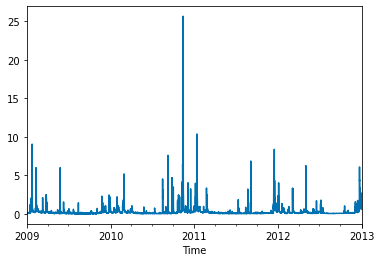

In [52]:
data['L06_347'].plot()

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

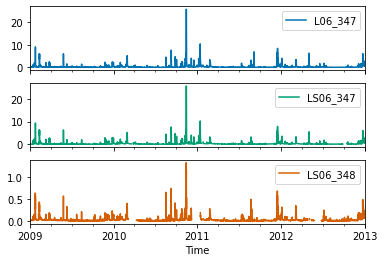

In [53]:
data.plot(subplots=True)

The steps above are provided as built-in functionality of `read_csv`:

In [54]:
data = pd.read_csv("data/vmm_flowdata.csv", index_col=0, parse_dates=True)

In [55]:
data.head()

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01 00:00:00,0.137417,0.097500,0.016833
2009-01-01 03:00:00,0.131250,0.088833,0.016417
2009-01-01 06:00:00,0.113500,0.091250,0.016750
2009-01-01 09:00:00,0.135750,0.091500,0.016250
2009-01-01 12:00:00,0.140917,0.096167,0.017000


<div class="alert alert-info">
<b>REMEMBER</b>: <br>

`pd.read_csv` provides a lot of built-in functionality to support this kind of transactions when reading in a file! Check the help of the read_csv function...
</div>

## The DatetimeIndex

When we ensure the DataFrame has a `DatetimeIndex`, time-series related functionality becomes available:

In [56]:
data.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 03:00:00',
               '2009-01-01 06:00:00', '2009-01-01 09:00:00',
               '2009-01-01 12:00:00', '2009-01-01 15:00:00',
               '2009-01-01 18:00:00', '2009-01-01 21:00:00',
               '2009-01-02 00:00:00', '2009-01-02 03:00:00',
               ...
               '2012-12-31 21:00:00', '2013-01-01 00:00:00',
               '2013-01-01 03:00:00', '2013-01-01 06:00:00',
               '2013-01-01 09:00:00', '2013-01-01 12:00:00',
               '2013-01-01 15:00:00', '2013-01-01 18:00:00',
               '2013-01-01 21:00:00', '2013-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Time', length=11697, freq=None)

Similar to a Series with datetime data, there are some attributes of the timestamp values available:

In [57]:
data.index.day

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
            ...
            31,  1,  1,  1,  1,  1,  1,  1,  1,  2],
           dtype='int64', name='Time', length=11697)

In [58]:
data.index.dayofyear

Int64Index([  1,   1,   1,   1,   1,   1,   1,   1,   2,   2,
            ...
            366,   1,   1,   1,   1,   1,   1,   1,   1,   2],
           dtype='int64', name='Time', length=11697)

In [59]:
data.index.year

Int64Index([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009,
            ...
            2012, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013],
           dtype='int64', name='Time', length=11697)

The `plot` method will also adapt it's labels (when you zoom in, you can see the different levels of detail of the datetime labels):


<AxesSubplot:xlabel='Time'>

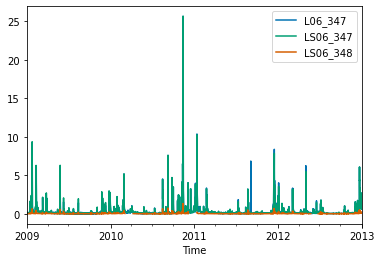

In [60]:
data.plot()

We have to much data to sensibly plot on one figure. Let's see how we can easily select part of the data or aggregate the data to other time resolutions in the next sections.

## Selecting data from a time series

We can use label based indexing on a timeseries as expected:

In [61]:
data[pd.Timestamp("2012-01-01 09:00"):pd.Timestamp("2012-01-01 19:00")]

,L06_347,LS06_347,LS06_348
Time,,,
2012-01-01 09:00:00,0.330750,0.293583,0.029750
2012-01-01 12:00:00,0.295000,0.285167,0.031750
2012-01-01 15:00:00,0.301417,0.287750,0.031417
2012-01-01 18:00:00,0.322083,0.304167,0.038083


But, for convenience, indexing a time series also works with strings:

In [62]:
data["2012-01-01 09:00":"2012-01-01 19:00"]

,L06_347,LS06_347,LS06_348
Time,,,
2012-01-01 09:00:00,0.330750,0.293583,0.029750
2012-01-01 12:00:00,0.295000,0.285167,0.031750
2012-01-01 15:00:00,0.301417,0.287750,0.031417
2012-01-01 18:00:00,0.322083,0.304167,0.038083


A nice feature is **"partial string" indexing**, where we can do implicit slicing by providing a partial datetime string.

E.g. all data of 2013:

In [63]:
data.loc['2013', :]

,L06_347,LS06_347,LS06_348
Time,,,
2013-01-01 00:00:00,1.688333,1.688333,0.207333
2013-01-01 03:00:00,2.693333,2.693333,0.201500
2013-01-01 06:00:00,2.220833,2.220833,0.166917
2013-01-01 09:00:00,2.055000,2.055000,0.175667
2013-01-01 12:00:00,1.710000,1.710000,0.129583
2013-01-01 15:00:00,1.420000,1.420000,0.096333
2013-01-01 18:00:00,1.178583,1.178583,0.083083
2013-01-01 21:00:00,0.898250,0.898250,0.077167
2013-01-02 00:00:00,0.860000,0.860000,0.075000


Normally you would expect this to access a column named '2013', but as for a DatetimeIndex, pandas also tries to interprete it as a datetime slice.

Or all data of January up to March 2012:

In [64]:
data['2012-01':'2012-03'].tail()

,L06_347,LS06_347,LS06_348
Time,,,
2012-03-31 09:00:00,0.104917,0.125000,0.012417
2012-03-31 12:00:00,0.098333,0.124417,0.011833
2012-03-31 15:00:00,0.091917,0.123917,0.011500
2012-03-31 18:00:00,0.085750,0.121417,0.011000
2012-03-31 21:00:00,0.068417,0.119750,0.010417


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>select all data starting from 2012</li>
</ul>
</div>

In [65]:
data.loc['2012':]

,L06_347,LS06_347,LS06_348
Time,,,
2012-01-01 00:00:00,0.307167,0.273917,0.028000
2012-01-01 03:00:00,0.302917,0.270833,0.030583
2012-01-01 06:00:00,0.331500,0.284750,0.030917
2012-01-01 09:00:00,0.330750,0.293583,0.029750
2012-01-01 12:00:00,0.295000,0.285167,0.031750
...,...,...,...
2013-01-01 12:00:00,1.710000,1.710000,0.129583
2013-01-01 15:00:00,1.420000,1.420000,0.096333
2013-01-01 18:00:00,1.178583,1.178583,0.083083


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>select all data in January for all different years</li>
</ul>
</div>

In [66]:
data.loc[data.index.month == 1]

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01 00:00:00,0.137417,0.097500,0.016833
2009-01-01 03:00:00,0.131250,0.088833,0.016417
2009-01-01 06:00:00,0.113500,0.091250,0.016750
2009-01-01 09:00:00,0.135750,0.091500,0.016250
2009-01-01 12:00:00,0.140917,0.096167,0.017000
...,...,...,...
2013-01-01 12:00:00,1.710000,1.710000,0.129583
2013-01-01 15:00:00,1.420000,1.420000,0.096333
2013-01-01 18:00:00,1.178583,1.178583,0.083083


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>select all data in January, February and March for all different years</li>
</ul>
</div>

In [67]:
data.loc[data.index.month.isin([1, 2, 3])]

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01 00:00:00,0.137417,0.097500,0.016833
2009-01-01 03:00:00,0.131250,0.088833,0.016417
2009-01-01 06:00:00,0.113500,0.091250,0.016750
2009-01-01 09:00:00,0.135750,0.091500,0.016250
2009-01-01 12:00:00,0.140917,0.096167,0.017000
...,...,...,...
2013-01-01 12:00:00,1.710000,1.710000,0.129583
2013-01-01 15:00:00,1.420000,1.420000,0.096333
2013-01-01 18:00:00,1.178583,1.178583,0.083083


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>select all 'daytime' data (between 8h and 20h) for all days</li>
</ul>
</div>

In [68]:
data[(data.index.hour >= 8) & (data.index.hour <= 20)]

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01 09:00:00,0.135750,0.091500,0.016250
2009-01-01 12:00:00,0.140917,0.096167,0.017000
2009-01-01 15:00:00,0.099167,0.091667,0.017583
2009-01-01 18:00:00,0.132667,0.090167,0.016250
2009-01-02 09:00:00,0.141917,0.097083,0.016417
...,...,...,...
2012-12-31 18:00:00,0.617333,0.617333,0.060583
2013-01-01 09:00:00,2.055000,2.055000,0.175667
2013-01-01 12:00:00,1.710000,1.710000,0.129583


In [69]:
data.query("8 <= index.dt.hour <= 20")

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01 09:00:00,0.135750,0.091500,0.016250
2009-01-01 12:00:00,0.140917,0.096167,0.017000
2009-01-01 15:00:00,0.099167,0.091667,0.017583
2009-01-01 18:00:00,0.132667,0.090167,0.016250
2009-01-02 09:00:00,0.141917,0.097083,0.016417
...,...,...,...
2012-12-31 18:00:00,0.617333,0.617333,0.060583
2013-01-01 09:00:00,2.055000,2.055000,0.175667
2013-01-01 12:00:00,1.710000,1.710000,0.129583


## The power of pandas: `resample`

A very powerfull method is **`resample`: converting the frequency of the time series** (e.g. from hourly to daily data).

The time series has a frequency of 1 hour. I want to change this to daily:

In [70]:
data.resample('D').mean().head()

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01,0.125010,0.092281,0.016635
2009-01-02,0.124146,0.095781,0.016406
2009-01-03,0.113562,0.085542,0.016094
2009-01-04,0.140198,0.102708,0.017323
2009-01-05,0.128812,0.104490,0.018167


<div class="alert alert-danger">

<b>NOTE</b>:

 <ul>
  <li>with older versions of pandas, <code>data.resample('D').mean()</code> was expressed as <code>data.resample('D', how='mean')</code>.</li>
</ul>
</div>

Other mathematical methods can also be specified:

In [71]:
data.resample('D').max().head()

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01,0.140917,0.097500,0.017583
2009-01-02,0.147833,0.101917,0.016833
2009-01-03,0.135833,0.092500,0.016833
2009-01-04,0.160417,0.113750,0.018417
2009-01-05,0.161500,0.115167,0.021583


<div class="alert alert-info">
<b>REMEMBER</b>: <br><br>
    The string to specify the new time frequency: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases <br><br>
    These strings can also be combined with numbers, eg `'10D'`...
</div>



<AxesSubplot:xlabel='Time'>

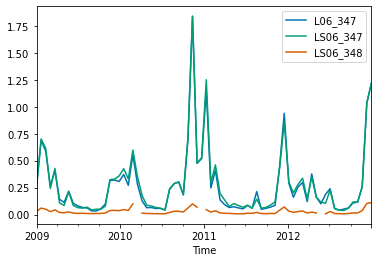

In [72]:
data.resample('20D').mean().plot()

<AxesSubplot:xlabel='Time'>

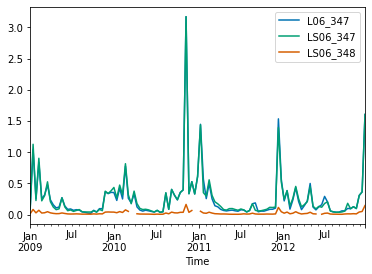

In [73]:
data.resample('12.5D').mean().plot()

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>plot the monthly standard deviation of the columns</li>
</ul>
</div>

<AxesSubplot:xlabel='Time'>

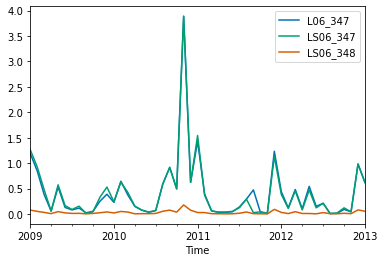

In [74]:
data.resample('M').std().plot()

In [101]:
data.resample('M').indices.values()

dict_values([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 2

In [104]:
a = [[1,2], [3,4], [5,6]]
[[a[i], a[i+1]] for i in range(len(a) - 1)]

[[[1, 2], [3, 4]], [[3, 4], [5, 6]]]

<div class="alert alert-success">
<b>EXERCISE</b>:
 <ul>
  <li>plot the monthly mean and median values for the years 2011-2012 for 'L06_347'</li>
 </ul>
</div>

<AxesSubplot:xlabel='Time'>

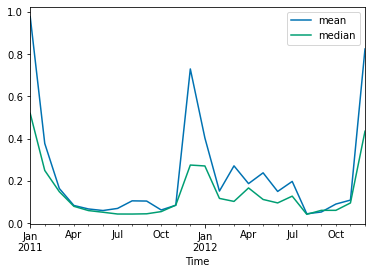

In [76]:
data.loc['2011':'2012', 'L06_347'].resample('M').agg(['mean', 'median']).plot()
# data.loc['2011':'2012'].resample('M').mean().plot()

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>plot the monthly mininum and maximum daily average value of the 'LS06_348' column</li>
</ul>
</div>

In [77]:
data.loc[:,'LS06_348'].resample('D').mean().agg(['min', 'max'])

min    0.004323
max    0.835854
Name: LS06_348, dtype: float64

<AxesSubplot:xlabel='Time'>

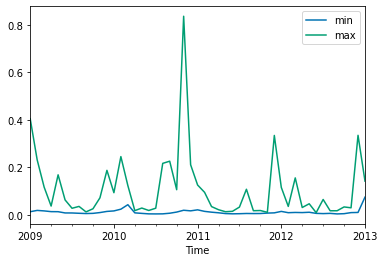

In [78]:
data.resample('D').mean().resample('M').agg(['min', 'max']).loc[:, 'LS06_348'].plot()

<div class="alert alert-success">
<b>EXERCISE</b>:

 <ul>
  <li>make a bar plot of the mean of the stations in year of 2013</li>
</ul>

</div>

In [79]:
data.loc[:,'LS06_348'].resample('D').mean().agg(['min', 'max'])

min    0.004323
max    0.835854
Name: LS06_348, dtype: float64

## Filling missing value

When filling missing values for temporal data it's common to use forward or backward filling/
With forward filling you propagate forward the last non-missing value. The opposite for backward filling.

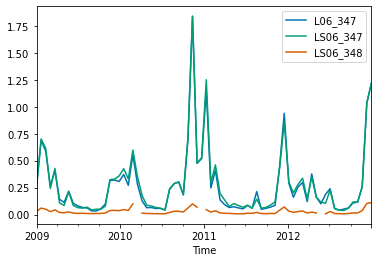

In [80]:
_ = data.resample('20D').mean().plot()

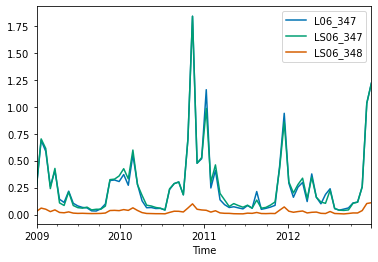

In [81]:
_ = data.fillna(method='ffill').resample('20D').mean().plot()

### Shifting data in time

In [82]:
index = pd.date_range(start="2021-10-24", periods=5, freq='1D')
index

DatetimeIndex(['2021-10-24', '2021-10-25', '2021-10-26', '2021-10-27',
               '2021-10-28'],
              dtype='datetime64[ns]', freq='D')

In [83]:
data = pd.DataFrame(np.arange(5, dtype=float), index=index)
data

,0
2021-10-24,0.0
2021-10-25,1.0
2021-10-26,2.0
2021-10-27,3.0
2021-10-28,4.0


In [84]:
data.shift(1)

,0
2021-10-24,NaN
2021-10-25,0.0
2021-10-26,1.0
2021-10-27,2.0
2021-10-28,3.0


In [85]:
data.shift(-1)

,0
2021-10-24,1.0
2021-10-25,2.0
2021-10-26,3.0
2021-10-27,4.0
2021-10-28,NaN


### Dealing with holidays

First let's look how to get the holidays between two dates

In [86]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2021-07-01', end='2021-07-31')
holidays

DatetimeIndex(['2021-07-05'], dtype='datetime64[ns]', freq=None)

<div class="alert alert-success">
<b>EXERCISE</b>:
<ul>
  <li>Add a column of bool to the DataFrame `df` to say if a date is a holiday</li>
</ul>
</div>

### Creating a holidays calendar for a new country

We'll use France as an example

In [87]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay

class FrBusinessCalendar(AbstractHolidayCalendar):
    """ Custom Holiday calendar for France based on
        https://en.wikipedia.org/wiki/Public_holidays_in_France
      - 1 January: New Year's Day
      - Moveable: Easter Monday (Monday after Easter Sunday)
      - 1 May: Labour Day
      - 8 May: Victory in Europe Day
      - Moveable Ascension Day (Thursday, 39 days after Easter Sunday)
      - 14 July: Bastille Day
      - 15 August: Assumption of Mary to Heaven
      - 1 November: All Saints' Day
      - 11 November: Armistice Day
      - 25 December: Christmas Day
    """
    rules = [
        Holiday('New Years Day', month=1, day=1),
        EasterMonday,
        Holiday('Labour Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption of Mary to Heaven', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas Day', month=12, day=25)
    ]

In [88]:
cal = FrBusinessCalendar()
holidays_fr = cal.holidays(start='2021-07-01', end='2021-07-31')
holidays_fr

DatetimeIndex(['2021-07-14'], dtype='datetime64[ns]', freq='<DateOffset: years=1>')

## Advanced grouping

### Using `pd.Grouper`

See: https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html

In [89]:
data = pd.read_csv("data/vmm_flowdata.csv")
data['Time'] = pd.to_datetime(data['Time'])
data.head()

,Time,L06_347,LS06_347,LS06_348
0,2009-01-01 00:00:00,0.137417,0.097500,0.016833
1,2009-01-01 03:00:00,0.131250,0.088833,0.016417
2,2009-01-01 06:00:00,0.113500,0.091250,0.016750
3,2009-01-01 09:00:00,0.135750,0.091500,0.016250
4,2009-01-01 12:00:00,0.140917,0.096167,0.017000


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11697 entries, 0 to 11696
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Time      11697 non-null  datetime64[ns]
 1   L06_347   11696 non-null  float64       
 2   LS06_347  11425 non-null  float64       
 3   LS06_348  10689 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 365.7 KB


<AxesSubplot:xlabel='Time'>

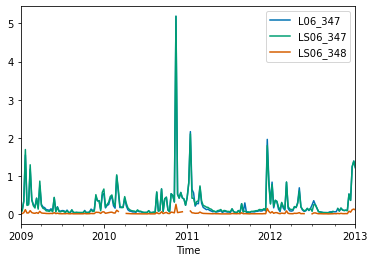

In [91]:
data.groupby(pd.Grouper(freq='1w', key='Time')).mean().plot()

### Using the `rolling` method

Rolling statistics are another type of time series-specific operation implemented by Pandas.
These can be accomplished via the ``rolling()`` attribute of ``Series`` and ``DataFrame`` objects, which returns a view similar to what we saw with the ``groupby`` operation.
This rolling view makes available a number of aggregation operations by default.

In [92]:
data = pd.read_csv("data/vmm_flowdata.csv")
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index('Time')
data.head()

,L06_347,LS06_347,LS06_348
Time,,,
2009-01-01 00:00:00,0.137417,0.097500,0.016833
2009-01-01 03:00:00,0.131250,0.088833,0.016417
2009-01-01 06:00:00,0.113500,0.091250,0.016750
2009-01-01 09:00:00,0.135750,0.091500,0.016250
2009-01-01 12:00:00,0.140917,0.096167,0.017000


First let's do a rolling based on row indices

<AxesSubplot:xlabel='Time'>

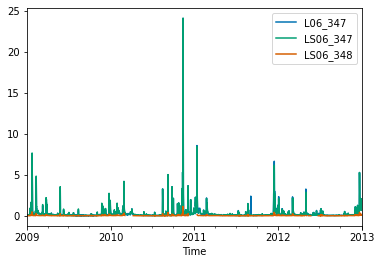

In [93]:
data.rolling(5, center=True).mean().plot()

It's also possible to use frequency for the rolling:

<AxesSubplot:xlabel='Time'>

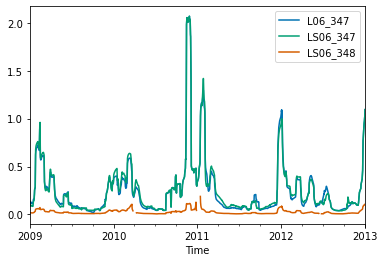

In [94]:
data.rolling('21D').mean().plot()

<div class="alert alert-success">
<b>EXERCISE</b>:
<ul>
  <li>Plot the standard deviation over a period of 10 days for the three columns.</li>
</ul>
</div>